All libraries can be installed with pip besides prophet. Install using conda install -c conda-forge fbprophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import aes, ggplot
import pathlib
from datetime import datetime
import xlrd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Import Datasets

Data from the following places will be used. I choose a to use only data from 2021-2023

- CPI (https://stats.oecd.org/index.aspx?DataSetCode=PRICES_CPI#)
- dollar (https://ru.investing.com/currencies/usd-zar-historical-data)
- petrol prices (https://www.energy.gov.za/files/esources/petroleum/petroleum_arch.html)

In [3]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [4]:
cpi = pd.read_csv(path + '/data/PRICES_CPI_27052023124702092.csv')
dollar = pd.read_csv(path + '/data/DEXSFUS.csv')
# TODO: need to read in petrol prices (currently on a pdf)

# EDA
## View CPI

In [5]:
cpi_columns = {'Food and non-Alcoholic beverages' : 'Food', 
               'All items': 'CPI',
               'Alcoholic beverages, tobacco and narcotics': 'Alcohol',
               'Clothing and footwear': 'Clothes',
               'Housing, water, electricity, gas and other fuels': 'Household', 
               'Transport': 'Transport',
               'Recreation and culture': 'Recreation', 
               'Health': 'Health',
               'Furnishings, household equipment and routine household maintenance': 'Furnishings',
               'Communication': 'Communication',
               'Education': 'Education',
               'Restaurants and hotels': 'Restaurants', 
               'Miscellaneous goods and services': 'Other services'}

In [6]:
# Select only where measure in Index
cpi = cpi[cpi['Measure'] == 'Index']

In [7]:
# get categories
cpi['cpi_cat'] = cpi['Subject'].apply(lambda x: x.split('- ')[-1])
cpi = cpi[cpi['cpi_cat'].isin(cpi_columns)][['Time', 'cpi_cat', 'Value']]

In [8]:
# change month to datetime format
cpi['Date'] = pd.to_datetime(cpi['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_12894/3347956333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [9]:
# map categories to shorter names
cpi = cpi.replace(cpi_columns)

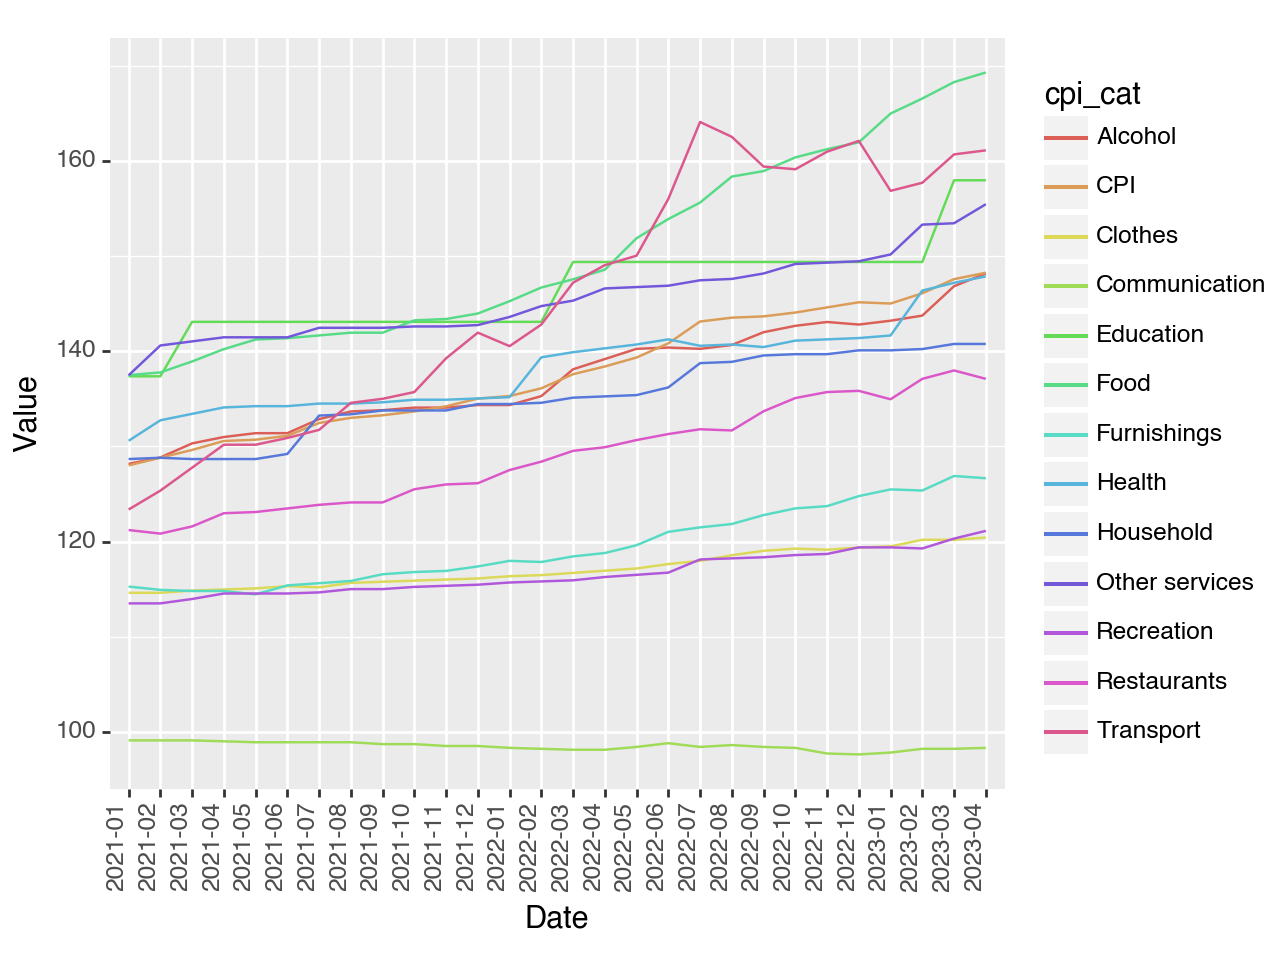

<Figure Size: (640 x 480)>

In [10]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

## Prophet model

## ALL CPI 

In [11]:
def train_predict_prophet(cpi, cat, pred_date):
    df = cpi[cpi['cpi_cat'] == cat]
    df = df[['Date', 'Value']]
    df.columns = ['ds', 'y']

    model = Prophet()
    model.fit(df)

    df_pred = pd.DataFrame({'ds':[pred_date]})
    df_pred['ds'] = pd.to_datetime(df_pred['ds'])

    df_model_pred = model.predict(df_pred)
    df_model_pred['cat'] = cat

    return df_model_pred


In [12]:
df_prophet_pred = []
for cat in cpi_columns.values():
    df_prophet_pred.append(train_predict_prophet(cpi=cpi, cat=cat, pred_date='30-Mar-2023'))

14:15:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:11 - cmdstanpy - INFO - Chain [1] done processing
14:16:11 - cmdstanpy - INFO - Chain [1] start processing
14:16:40 - cmdstanpy - INFO - Chain [1] done processing
14:16:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:37 - cmdstanpy - INFO - Chain [1] done processing
14:17:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:34 - cmdstanpy - INFO - Chain [1] done processing
14:18:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:03 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing
14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1]

In [63]:
df_pred_all = pd.concat(df_prophet_pred)

In [64]:
df_pred_all.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cat
0,2023-03-30,170.880262,162.603850,162.603850,170.880262,170.880262,-8.276412,-8.276412,-8.276412,-8.276412,-8.276412,-8.276412,0.0,0.0,0.0,162.603850,Food
0,2023-03-30,147.838541,148.761301,148.761301,147.838541,147.838541,0.922760,0.922760,0.922760,0.922760,0.922760,0.922760,0.0,0.0,0.0,148.761301,CPI
0,2023-03-30,146.403383,149.557259,149.557259,146.403383,146.403383,3.153875,3.153875,3.153875,3.153875,3.153875,3.153875,0.0,0.0,0.0,149.557259,Alcohol
0,2023-03-30,120.809792,121.493335,121.493335,120.809792,120.809792,0.683542,0.683542,0.683542,0.683542,0.683542,0.683542,0.0,0.0,0.0,121.493335,Clothes
0,2023-03-30,141.589995,140.574633,140.574633,141.589995,141.589995,-1.015362,-1.015362,-1.015362,-1.015362,-1.015362,-1.015362,0.0,0.0,0.0,140.574633,Household


# Get submission file

In [65]:
df_sub = df_pred_all[['cat', 'trend']]
df_sub.columns = ['ID', 'Value']

In [66]:
month = 'May'

In [67]:
pred_map = {'CPI': f'{month}_headline CPI',
'Alcohol': f'{month}_alcoholic beverages and tobacco',
'Clothes': f'{month}_clothing and footwear',
'Communication': f'{month}_communication',
'Education': f'{month}_education',
'Food': f'{month}_food and non-alcoholic beverages',
'Health': f'{month}_health',
'Furnishings': f'{month}_household contents and services',
'Household': f'{month}_housing and utilities',
'Other services': f'{month}_miscellaneous goods and services',
'Recreation': f'{month}_recreation and culture',
'Restaurants': f'{month}_restaurants and hotels',
'Transport': f'{month}_transport'}

In [68]:
df_sub = df_sub.replace(pred_map)

In [69]:
df_sub.to_csv(path + '/submissions/v1_prophet.csv', index=False)